In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

In [2]:
# 모델 구축을 위한 노드 개수 지정
# 100 -> 4 -> 2

nb_inputs = 100 # 입력층 노드 개수
nb_hidden = 4   # 은닉층 노드 개수
nb_outputs = 2  # 출력층 노드 개수(이진 분류)

In [3]:
# RNN 모델을 위한 변수 설정

time_step = 1e-3    # 시간 상수(시간 단위, 0.001)
nb_steps = 200      # 시간 상수 개수(0.001 * 200 = 0.2초 시뮬레이션)

In [4]:
# 병렬성을 위해 배치사이즈 지정

# 신경망 배치 크기 지정
batch_size = 256

In [5]:
# CUDA 설정 또는 CPU 지정

# 데이터 타입 지정
dtype = torch.float

# CUDA 실행 가능 여부 확인
print("CUDA Available:", torch.cuda.is_available())

# 가능할 경우 CUDA 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

CUDA Available: True


device(type='cuda', index=0)

In [6]:
# 주파수(Hz, 헤르츠) - 단위 시간(time_step) 당 평균 스파이크 개수
# 임의의 입력 데이터 생성을 위한 데이터 생성
freq = 5

# prob - 생성할 데이터의 스파이크 발화확률 ( 주파수 * 시간 상수 )
prob = freq * time_step
prob

0.005

In [7]:
# mask - [배치크기, 단위시간, 입력노드]
# 0.0 ~ 1.0 의 랜덤한 입력 데이터 생성

mask = torch.rand((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype)
print("Shape:", mask.shape)

mask[0]

Shape: torch.Size([256, 200, 100])


tensor([[0.6926, 0.4841, 0.8320,  ..., 0.2764, 0.0478, 0.9828],
        [0.6704, 0.5551, 0.6596,  ..., 0.8323, 0.8261, 0.9939],
        [0.6068, 0.5457, 0.0872,  ..., 0.6212, 0.4575, 0.5053],
        ...,
        [0.1101, 0.9195, 0.2206,  ..., 0.8712, 0.5468, 0.4095],
        [0.9123, 0.6207, 0.3295,  ..., 0.4998, 0.2794, 0.2694],
        [0.6701, 0.3397, 0.3622,  ..., 0.1494, 0.4798, 0.3939]],
       device='cuda:0')

In [8]:
# x_data - 입력 데이터 생성 mask 값보다 작으면 스파이크로 지정 주파수 * 시간 상수 = 0.005

x_data = torch.zeros((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype, requires_grad=False)
x_data[mask < prob] = 1.0

x_data.shape

torch.Size([256, 200, 100])

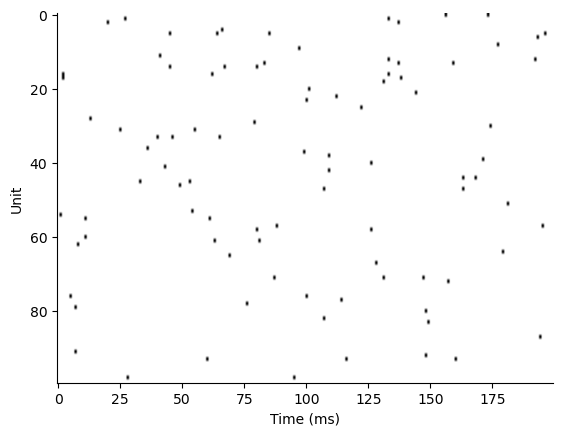

In [9]:
# 배치 123 번째 데이터 검색, 입력데이터(100), 한 줄에 하나의 입력이며, 점이 스파이크 발생 여부
# cpu(): 행렬을 cpu 공간으로 이동, CPU로 이동해 출력하거나 연산하는 것이 효율적이다.
# t: 전치, 행과 열을 바꾸는 것
# 점찍힌 것이 스파이크 발생

data_id = 123

plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

In [10]:
# 라벨 데이터 생성
# 이진 분류 데이터
# 라벨 데이터가 배치 사이즈 크기를 가지는 이유? 배치크기가 곧 데이터 사이즈를 의미함
# 입력 데이터는 256, 200, 100인데, 100개의 입력과 1개의 출력되는 데이터가 200ms의 시뮬레이션 시간을 가지며, 데이터의 량은 256개.
# 따라서 데이터 양이 늘어날 수록 해당 코드를 반복하면 된다.

y_data = torch.tensor(1 * (np.random.rand(batch_size) < 0.5), device=device)

print("y_data 라벨 데이터:", y_data.shape)
print("torch.bincount(y_data) 각 라벨의 데이터 개수:", torch.bincount(y_data))  # 고르게 분포된 것을 확인

y_data 라벨 데이터: torch.Size([256])
torch.bincount(y_data) 각 라벨의 데이터 개수: tensor([134, 122], device='cuda:0')


In [11]:
y_data

tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')

In [12]:
'''SNN 모델 설정'''

'SNN 모델 설정'

In [13]:
# 막 시간 상수, 입력 신호의 처리 속도
tau_mem = 10e-3

# 시냅스 시간 상수, 입력 신호에 변화 속도
tau_syn = 5e-3

# 매개변수 alpha, beta는 의미 있는 범위에서 조정 가능
alpha = float(np.exp(-time_step / tau_syn))
beta = float(np.exp(-time_step / tau_mem))

print("alpha:", alpha)
print("beta:", beta)

alpha: 0.8187307530779818
beta: 0.9048374180359595


In [14]:
# 가중치 규모, 시작부터 스파이크의 발생을 유도
# 학습 안정성과 효율성 증가, 입력신호에 민감하지 않으면 학습이 제대로 되지 않을 수 있음
weight_scale = 7 * (1.0 - beta)

print("weight_scale:", weight_scale)

weight_scale: 0.6661380737482834


In [15]:
# normal_: 가중치 텐서 초기화, 정규 분포의 평균 값과 정규 분포의 표준 편차 값을 이용(He 초기값과 유사한 방법)
# 스파이크 발생은 가중치 * 입력 신호 > 막전위 임계 일 때 발생한다.
w1 = torch.empty((nb_inputs, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale / np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale / np.sqrt(nb_hidden))

print("w1.shape:", w1.shape)
print("w2.shape:", w2.shape)

print(w1)

w1.shape: torch.Size([100, 4])
w2.shape: torch.Size([4, 2])
tensor([[ 0.0854, -0.0206,  0.0963, -0.0028],
        [-0.1344, -0.0098, -0.0084, -0.0119],
        [-0.0500, -0.0065,  0.0022, -0.0452],
        [ 0.0880, -0.0832, -0.0339,  0.0718],
        [ 0.0980,  0.1008,  0.0362, -0.0089],
        [-0.0288,  0.1224, -0.0160, -0.0482],
        [-0.1086, -0.1666, -0.1240, -0.0546],
        [-0.0136,  0.0138,  0.0791, -0.0037],
        [-0.0350,  0.0321, -0.0016,  0.0472],
        [-0.1834,  0.0848,  0.0301, -0.0703],
        [ 0.0257, -0.0827,  0.0355, -0.0401],
        [-0.0216, -0.0547,  0.0065, -0.1303],
        [ 0.1084, -0.1019, -0.0850, -0.0722],
        [-0.1549,  0.0740, -0.0514, -0.0334],
        [ 0.0481,  0.0162,  0.1372,  0.0204],
        [-0.0320, -0.0776,  0.0215,  0.0246],
        [ 0.0681, -0.0642, -0.0320,  0.0524],
        [-0.0663,  0.0528,  0.0407,  0.0513],
        [ 0.0528,  0.0370,  0.0837, -0.0371],
        [-0.0602, -0.0600,  0.0636,  0.0032],
        [ 0.0248, -0

In [16]:
'''이산 시간에서 스파이크 뉴런 모델'''

'이산 시간에서 스파이크 뉴런 모델'

In [17]:
# einsum: Einstein Summation, 선형 대수 개념으로 특정 차원에서 곱셈과 합산을 적용하는 방법
# 아인슈타인 합산: 복잡한 차원의 텐서를 문자열로 계산해주는 함수

# h1은 입력데이터와 layer1(w1)에 연결의 가중치 행렬 곱의 합 결과 값
h1 = torch.einsum("abc,cd->abd", (x_data, w1))

# 배치, 시간, 뉴런(은닉층의 개수)
print("h1.shape:", h1.shape)
print(h1)

h1.shape: torch.Size([256, 200, 4])
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0481,  0.0162,  0.1372,  0.0204],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.0136,  0.0138,  0.0791, -0.0037],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.1623, -0.0126,  0.0538,  0.0305]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0127, -0.0423, -0.0474,  0.0891],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[-0.0203, -0.1275,  0.1181,  0.0201],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0689, -0.0997, -0.0673, -0.1340],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         

In [18]:
# Heaviside 함수, 헤비사이드 함수 선언
# 0보다 크면 1, 0보다 작으면 0
def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    
    return out

testHeaviside = torch.tensor([1.2345, -2.3456, 0], dtype=dtype)

print(testHeaviside)
print(spike_fn(testHeaviside))

tensor([ 1.2345, -2.3456,  0.0000])
tensor([1., 0., 0.])


In [19]:
# 시냅스 전류 초기화, 막전위 초기화
syn = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
mem = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)

# 배치사이즈, 은닉층 노드
print("syn.shape:", syn.shape)
print("mem.shape:", mem.shape)

syn.shape: torch.Size([256, 4])
mem.shape: torch.Size([256, 4])


In [20]:
# 시냅스, 막전위 기록
mem_rec = []
spk_rec = []

print("nb_steps:", nb_steps)

# 간결성을 위해 리셋전위: 0, R(저항): 1, v: 1 로 설정 
for t in range(nb_steps):
    # 출력 S_i(t)를 만드는 코드, reset 함수
    mthr = mem - 1.0 # 1.0은 v=1 값.
    out = spike_fn(mthr)
    rst = out.detach()   # 기울기 계산하지 않음
    
    # I_i(t)를 만드는 코드, 시냅스 역학 근사화, input 함수 h1은 가중치, W, V 수식과 동일
    # h1[:, t] == h1[:, t, :], h1.shape = 256(batch), 200(time), 4(hidden node)
    new_syn = alpha * syn + h1[:, t] # 순환(V)가 어디?
    
    # U_i(t+1)를 만드는 코드, leak 함수
    # rst는 위에서 만든 S_i(t)
    new_mem = (beta * mem + syn) * (1.0 - rst) # 1.0은 무슨 값?
    
    mem_rec.append(mem)
    spk_rec.append(out)
    
    mem = new_mem
    syn = new_syn

print("Simulation OK")

nb_steps: 200
Simulation OK


In [21]:
mem_rec = torch.stack(mem_rec, dim=1)
spk_rec = torch.stack(spk_rec, dim=1)

print("mem_rec.shape:", mem_rec.shape)
print("spk_rec.shape:", spk_rec.shape)

mem_rec.shape: torch.Size([256, 200, 4])
spk_rec.shape: torch.Size([256, 200, 4])


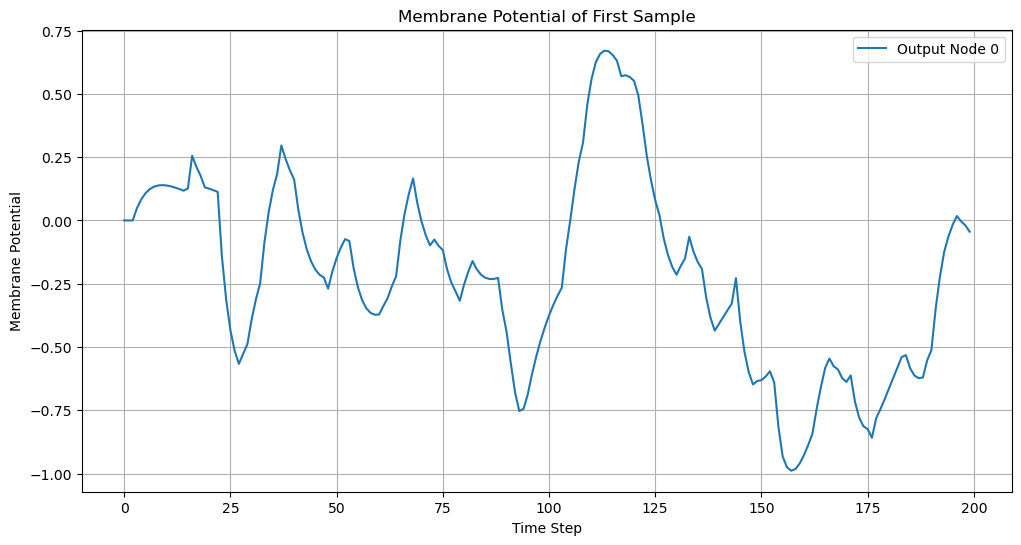

In [22]:
import matplotlib.pyplot as plt
import torch

# 시각화 설정
plt.figure(figsize=(12, 6))
plt.plot(mem_rec[0, :, 0].cpu().detach().numpy(), label='Output Node 0')

plt.title('Membrane Potential of First Sample')
plt.xlabel('Time Step')
plt.ylabel('Membrane Potential')
plt.legend()
plt.grid(True)
plt.show()


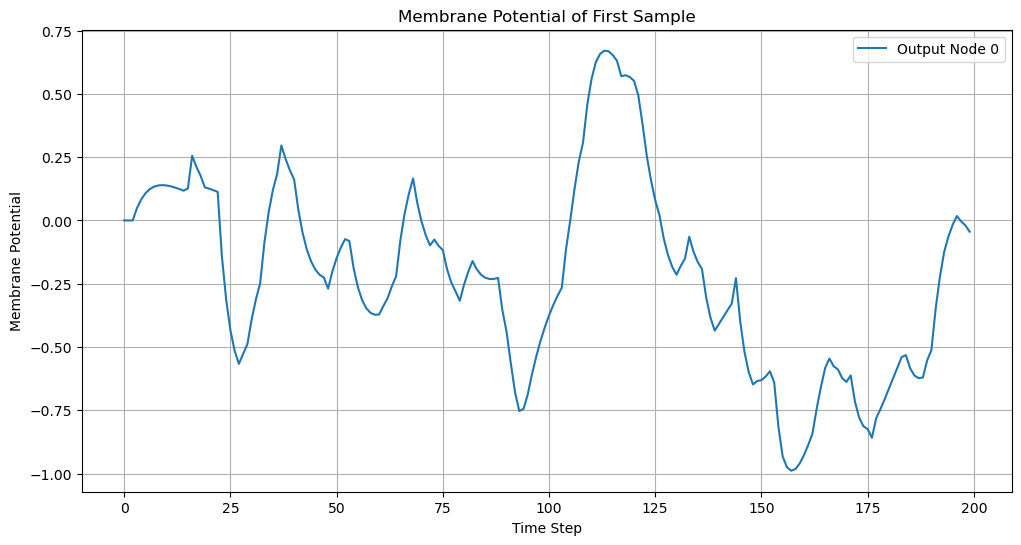

In [23]:
import matplotlib.pyplot as plt
import torch

# 시각화 설정
plt.figure(figsize=(12, 6))
plt.plot(mem_rec[0, :, 0].cpu().detach().numpy(), label='Output Node 0')

# spk_rec이 1인 경우 세로 줄 추가
time_steps = torch.arange(mem_rec.size(1))
for t in time_steps[spk_rec[0, :, 0].cpu() == 1]:
    plt.axvline(x=t, color='r', linestyle='-')  # 스파이크 발생 시점에 빨간색 점선 세로 줄 추가

plt.title('Membrane Potential of First Sample')
plt.xlabel('Time Step')
plt.ylabel('Membrane Potential')
plt.legend()
plt.grid(True)
plt.show()

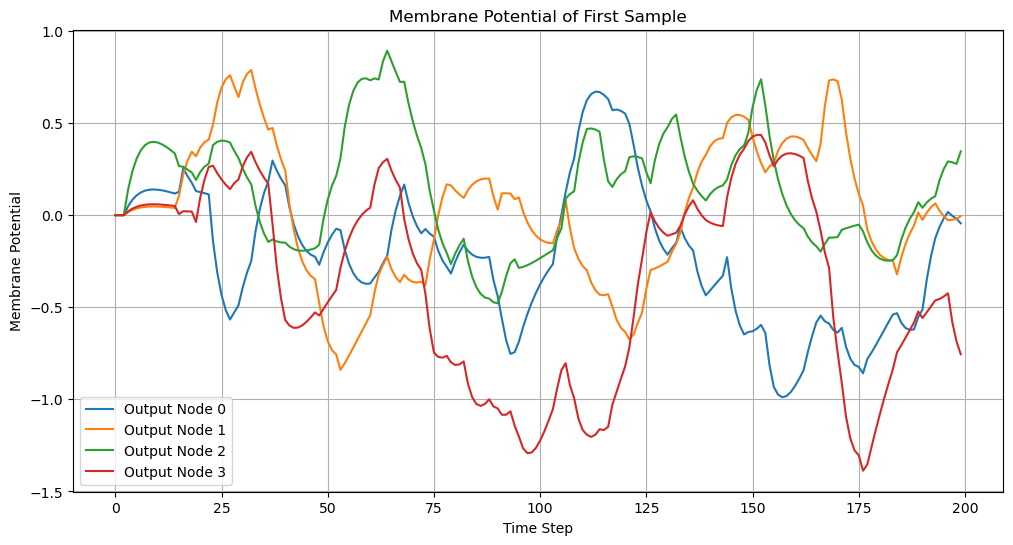

In [24]:
import matplotlib.pyplot as plt
import torch

# 시각화 설정
plt.figure(figsize=(12, 6))
plt.plot(mem_rec[0, :, 0].cpu().detach().numpy(), label='Output Node 0')
plt.plot(mem_rec[0, :, 1].cpu().detach().numpy(), label='Output Node 1')
plt.plot(mem_rec[0, :, 2].cpu().detach().numpy(), label='Output Node 2')
plt.plot(mem_rec[0, :, 3].cpu().detach().numpy(), label='Output Node 3')

plt.title('Membrane Potential of First Sample')
plt.xlabel('Time Step')
plt.ylabel('Membrane Potential')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# 그림을 격자로 배치하는 라이브러리
from matplotlib.gridspec import GridSpec

# mem: mem_rec으로 연속된 막전위가 저장된 토치
# spk: spk_rec으로 스파이크 발생 여부 저장
# dim: 세로 3, 가로 5 지정 후 격자로 출력
# spike_height: 그래프에서 스파이크를 출력할 y값
def plot_voltage_traces(mem, spk=None, dim=(3, 5), spike_height=5):
    gs = GridSpec(*dim)
    
    if spk is not None:
        dat = 1.0 * mem
        
        # 스파이크 일 경우 spike_height의 y값을 가짐
        dat[spk > 0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    
    # 행x열 만큼 반복
    for i in range(np.prod(dim)):
        if i == 0:
            a0 = ax = plt.subplot(gs[i])
        else:
            # sharey -> 공유y y축의 값을 서로(a0와 ax) 공유
            ax = plt.subplot(gs[i], sharey = a0)
        
        ax.plot(dat[i])
        ax.axis("off")

In [26]:
print("mem_rec.shape:", mem_rec.shape)
print("mem_rec.shape:", spk_rec.shape)

mem_rec.shape: torch.Size([256, 200, 4])
mem_rec.shape: torch.Size([256, 200, 4])


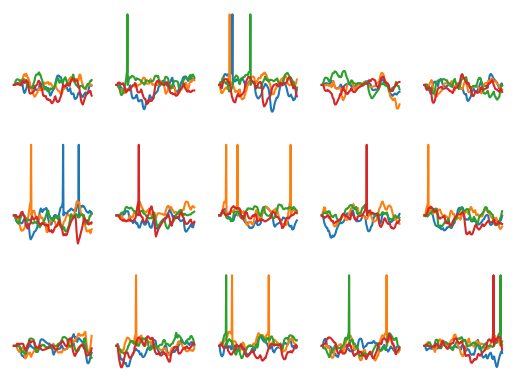

In [27]:
# 256개의 출력 데이터(node(4)) 중 15개의 스파이크 발생을 그래프로 출력
fig = plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

In [28]:
dim = (3, 6)
np.prod(dim)

18

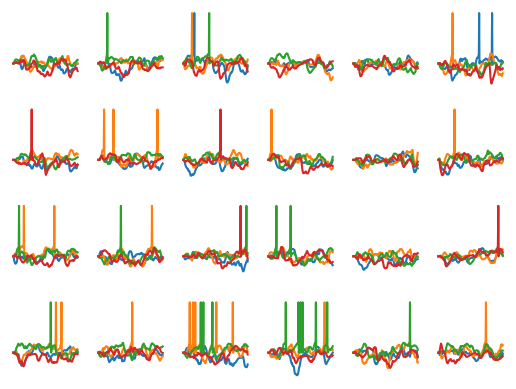

In [29]:
fig = plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec, dim=(4, 6))

In [30]:
#SNN 함수 실행코드 
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))                          # 입력과 가중치를 계산해 h1을 생성
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)   # 시냅스 전위 초기화
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)   # 막전위 초기화

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        # 출력 S_i(t)를 만드는 코드, reset 함수
        mthr = mem - 1.0 # 1.0은 v=1 값.
        out = spike_fn(mthr)
        rst = out.detach()   # 기울기 계산하지 않음

        # I_i(t)를 만드는 코드, 시냅스 역학 근사화, input 함수 h1은 가중치, W, V 수식과 동일
        # h1[:, t] == h1[:, t, :], h1.shape = 256(batch), 200(time), 4(hidden node)
        new_syn = alpha * syn + h1[:, t] # 순환(V)가 어디? : 해당 예시에서는 없음

        # U_i(t+1)를 만드는 코드, leak 함수
        # rst는 위에서 만든 S_i(t)
        new_mem = (beta * mem + syn) * (1.0 - rst) # 1.0은 무슨 값?

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec, dim=1)
    spk_rec = torch.stack(spk_rec, dim=1)

    # Readout layer
    # 두번째 출력 레이어
    
    # 아인슈타인 합산 수식 설정 spk_rec(배치(데이터), 단위시간, 은닉층 뉴런수) w2(은닉층 뉴런수, 출력노드 뉴런수)
    h2 = torch.einsum("abc,cd->abd", (spk_rec, w2))
    
    # (256, 2) 크기로 초기화, (배치(데이터) 크기, 출력 뉴런) -> 1레이어의 shape에 의해 256이며, 출력 레이어에 의해 2
    flt = torch.zeros((batch_size, nb_outputs), device=device, dtype=dtype) # 막전위(불확실)
    out = torch.zeros((batch_size, nb_outputs), device=device, dtype=dtype) # 스파이크(불확실)
    out_rec = [out]
    
    # 단위시간 동안 반복
    for t in range(nb_steps):
        # 시냅스 역학 근사화 I(t+1) 다음 레이어 막전위 값 계산
        new_flt = alpha * flt + h2[:, t]
        
        # 다음 레이어의 막역학 U(t+1) 다음 레이어 스파이크 값 계산
        new_out = beta * out + flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    # 출력 저장 (데이터, 단위시간+1, 출력) +1? 시작(out 변수) 0부터
    out_rec = torch.stack(out_rec, dim=1)
    
    # 막전위와 스파이크 기록 저장
    other_recs = [mem_rec, spk_rec]
    
    return out_rec, other_recs

In [31]:
out_rec, other_recs = run_snn(x_data)

print("out_rec:", out_rec.shape)
print("len(other_recs):", len(other_recs))
print("other_recs[0].shape:", other_recs[0].shape)
print("other_recs[1].shape:", other_recs[1].shape)

out_rec: torch.Size([256, 201, 2])
len(other_recs): 2
other_recs[0].shape: torch.Size([256, 200, 4])
other_recs[1].shape: torch.Size([256, 200, 4])


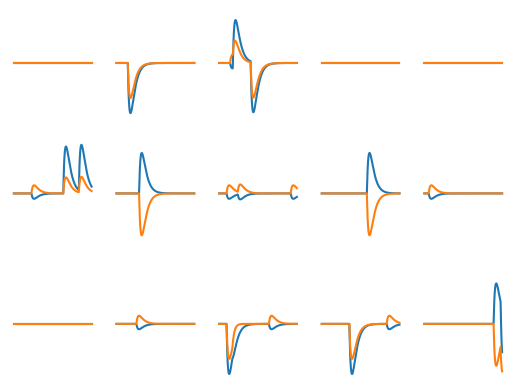

In [32]:
# 각 출력 노드의 막전위 그래프, 앞의 15개 데이터에 대한 결과값
fig = plt.figure(dpi=100)
plot_voltage_traces(out_rec)

In [33]:
# 입력 -> 은닉 사이의 최대값: 단위시간에서 가장 큰 막전위 탐색, 가장 활성화된 상태를 나타냄
# 1은 차원지정, out_rec.shape: (256, 200, 4) 인데 200에서 찾기
m, mIdx = torch.max(out_rec, 1)

print("m.shape:", m.shape)
print("m[0:10]:\n", m[0:10])
print("mIdx[0:10]:\n", mIdx[0:10])

m.shape: torch.Size([256, 2])
m[0:10]:
 tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.6904, 0.3589],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.7821, 0.2669],
        [0.6513, 0.0000],
        [0.0000, 0.1448],
        [0.6513, 0.0000],
        [0.0000, 0.1307]], device='cuda:0', grad_fn=<SliceBackward0>)
mIdx[0:10]:
 tensor([[  0,   0],
        [  0,   0],
        [ 42,  41],
        [  0,   0],
        [  0,   0],
        [174, 174],
        [ 65,   0],
        [  0,  54],
        [123,   0],
        [  0,  18]], device='cuda:0')


In [34]:
m, mIdx = torch.max(m, 1)
mIdx

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')

In [35]:
# 막전위가 가장 큰 값을 찾아 그 인덱스를 출력층 라벨 지정
def print_classification_accuracy():
    """ Dirty little helper function to compute classification accuracy. """
    output, other_recs = run_snn(x_data)  # 모델 학습
    maxValue1, idx = torch.max(output, 1) # max over time
    maxValue2, idx2 = torch.max(maxValue1, 1) # argmax over output units
    acc = np.mean((y_data == idx2).detach().cpu().numpy()) # compare to labels
    print(f"Model Accuracy: {acc * 100:2.3F}%")
    
print_classification_accuracy()

Model Accuracy: 51.562%


In [36]:
# 지도학습

In [37]:
# 가중치 w1(입력->은닉 레이어 뉴런) w2(은닉->출력 레이어 뉴런)

params = [w1, w2]                                                   # 가중치 매개변수 지정

# 최적화함수 파라미터 lr(learning rate), betas(0.0~1.0 float, general 0.9~0.999)
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9, 0.999))    # 최적화 함수 지정

# 네트워크 가중치 최적화를 위해 활성화 함수 지정
log_softmax_fn = nn.LogSoftmax(dim=1)                               # 출력층 활성화 함수로 소프트맥스 지정

# 소프트맥스 함수를 지난 후 사용하는 경우가 일반적
# The negative log likelihood loss function
loss_fn = nn.NLLLoss()

# The optimization loop
loss_hist = []
for e in range(1000):   # 일반적인 학습의 과정과 동일
    # run the network and get output
    output, _others_rec = run_snn(x_data) # 학습 단계(순전파) 
    # compute the loss
    m, _maxIndex = torch.max(output,1)    # 은닉층 최대값 계산 output.shape (,2)
    log_p_y = log_softmax_fn(m)           # 출력 활성화 함수
    loss_val = loss_fn(log_p_y, y_data)   # 화렁화 함수 후 오차 계산
    
    # 100회 마다 오차를 출력
    if e % 100 == 0:
        print(f"epoch: {e} | loss_val:", loss_val)

    # update the weights
    optimizer.zero_grad() # 최적화 함수 가중치 초기화
    loss_val.backward()   # 오차를 통해 역전파 발산
    optimizer.step()      # 최적화 함수 갱신
    
    # 오차값 리스트 저장
    loss_hist.append(loss_val.item())
    
loss_hist_true_grad = loss_hist # 저장한 오차값 리스트 저장

epoch: 0 | loss_val: tensor(0.6954, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 100 | loss_val: tensor(0.6885, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 200 | loss_val: tensor(0.6881, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 300 | loss_val: tensor(0.6878, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 400 | loss_val: tensor(0.6860, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 500 | loss_val: tensor(0.6851, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 600 | loss_val: tensor(0.6844, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 700 | loss_val: tensor(0.6838, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 800 | loss_val: tensor(0.6833, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 900 | loss_val: tensor(0.6829, device='cuda:0', grad_fn=<NllLossBackward0>)


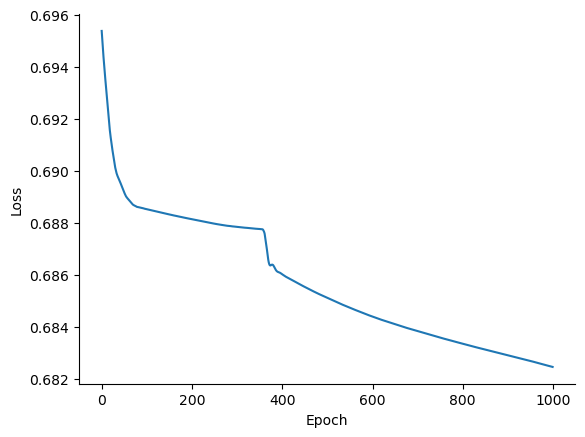

In [38]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [39]:
# 이전 정확도 Model Accuracy: 50.781%
# 증가 이유: 반복된 학습을 통한 최적화
# 그렇게 차이나지 않는 이유: 은닉층의 비선형성이 무한해지는 임계값 교차점을 제외한 모든 곳에서 도함수가 0이기 때문에 학습이 제대로 되지 않음
# 따라서 은닉층(w1)의 가중치 값이 업데이트되지 않고 유지됨
# 은닉층 가중치들이 학습되도록 수정되어야 함
print_classification_accuracy()

Model Accuracy: 52.344%


In [40]:
# Surrogate Gradient 사용
# 이진 비선형성을 유지하면서, 도함수가 0이 되는 것을 방지. 일반적으론 ReLU 사용
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    
    여기서 우리는 서브그래디언트를 구현하는 스파이킹 비선형성을 구현합니다.
    torch.autograd.Function을 서브클래싱하여 PyTorch의 autograd 기능을 모두 사용할 수 있습니다.
    여기서는 Zenke & Ganguli (2018)에서 한 것처럼 빠른 시그모이드의 정규화된 음수 부분을 사용합니다.
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        
        순전파에서는 입력 텐서의 계단 함수를 계산하여 반환합니다.
        ctx는 나중에 오차 신호를 역전파할 때 필요한 정보를 저장하는 데 사용하는 컨텍스트 객체입니다.
        이를 위해 ctx.save_for_backward 메서드를 사용합니다.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        
        역전파에서는 입력에 대한 손실의 서브그래디언트를 계산해야 하는 텐서를 받습니다.
        여기서는 Zenke & Ganguli (2018)에서 한 것처럼 빠른 시그모이드의 정규화된 음수 부분을 사용합니다.
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale * torch.abs(input) + 1.0)**2
        
        return grad

In [ ]:
# Surrogate Gradient 사용
# 이진 비선형성을 유지하면서, 도함수가 0이 되는 것을 방지. 일반적으론 ReLU 사용
class SurrGradSpike(torch.autograd.Function):
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale * torch.abs(input) + 1.0)**2
        
        return grad

In [41]:
spike_fn = SurrGradSpike.apply

In [42]:
# The following lines will reinitialize the weights
# torch.nn.init.normal_(초기화 가중치 텐서, 정규 분포의 평균 값, 정규 분포의 표준 편차)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale / np.sqrt(nb_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale / np.sqrt(nb_hidden))
print("init done")

init done


In [43]:
# 새로운 Surrogate gradient 사용
params = [w1, w2]
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999))

log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

loss_hist = []
for e in range(1000):
    output, _others_recs = run_snn(x_data) # 순전파
    m, _maxIndex = torch.max(output, 1)    # 최대값 계산
    log_p_y = log_softmax_fn(m)            # 활성화 함수
    loss_val = loss_fn(log_p_y, y_data)    # 오차 계산

    if e % 100 == 0:
        print(f"epoch: {e} | loss_val:", loss_val)

    optimizer.zero_grad()                  # 최적화 함수 기울기 초기화
    loss_val.backward()                    # 오차 기반 역전파 발산
    optimizer.step()                       # 최적화 함수 갱신
    loss_hist.append(loss_val.item())      # 오차 리스트 저장

epoch: 0 | loss_val: tensor(0.7476, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 100 | loss_val: tensor(0.4789, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 200 | loss_val: tensor(0.2522, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 300 | loss_val: tensor(0.1626, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 400 | loss_val: tensor(0.1215, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 500 | loss_val: tensor(0.0774, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 600 | loss_val: tensor(0.0629, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 700 | loss_val: tensor(0.0518, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 800 | loss_val: tensor(0.0576, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch: 900 | loss_val: tensor(0.0431, device='cuda:0', grad_fn=<NllLossBackward0>)


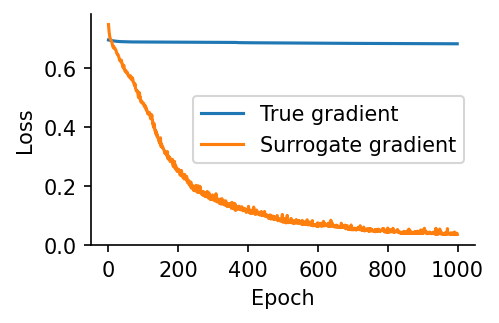

In [44]:
plt.figure(figsize=(3.3,2), dpi=150)
plt.plot(loss_hist_true_grad, label="True gradient")
plt.plot(loss_hist, label="Surrogate gradient")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
sns.despine()

In [45]:
output, _others_recs = run_snn(x_data)
m, _maxIndex = torch.max(output, 1)
maxValue, am = torch.max(m, 1)
acc = np.mean((y_data == am).detach().cpu().numpy())

print(f"Accuracy: {acc * 100:2.3F}%")

Accuracy: 98.438%
